# $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Tryst with Data Robot with Quality Wine
### $\;\;\;\;\;\;\;\;\;$ Getting started with using DataRobot python API for multi-class classification
###### $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Shaheen Gauher, PhD 

<img src="https://raw.githubusercontent.com/shaheeng/DataRobot/master/pythonAPI/image_drblog.PNG">

Recently, I had the opportunity to explore [DataRobot](https://www.datarobot.com/). As a hardcore pythonic data scientist, I was curious about its capabilities and wondered if it would help expedite my work. DataRobot promises [automated machine learning](https://www.datarobot.com/product/automated-machine-learning/) wherein it chooses the most appropriate machine learning algorithms, automatically optimizes data preprocessing, applies feature engineering, and tunes parameters for each algorithm. It creates and ranks highly accurate [models](https://www.datarobot.com/wiki/model/) and recommends the best model to deploy for the data and prediction target. So when the opportunity to use DataRobot presented itself, I decided to give it a try. 

So far, I have been quite pleased with the functionality and was able to integrate it into my pythonic workflow. I have consolidated my DataRobot exploration into this tutorial on ***Getting started with using DataRobot python API for multi-class classification***. Hopefully, this will help you understand how DataRobot works and expedite the onboarding process for your data science needs within your enterprise.

For this tutorial, I used the [wine quality data set](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the UCI Machine Learning Repository. The dataset contains quality ratings (labels) for 4,898 white wine samples. The features are the wines’ physical and chemical properties (11 predictors). We want to use these physicochemical properties to predict the quality of the wine. Here is a brief outline of of the steps : I will start by [creating the training data](#ctd) that will be sent to Data Robot modelling engine. Next I will [establish connection to Data Robot](#ec) through my python session and create three different projects to showcase the three different modes Data Robot can work with on my data. The thee modes are the [full autopilot mode](#full), the [quick autopilot mode](#quick) and the [manual mode](#manual). I will call the three projects corresponding to the three modes project_wine1, project_wine2, and project_wine3. Once the training process is complete, I will show how to retrieve the results from the various models and how to generate predictions on new data using a selected model. 

In [1]:
import sys
import pandas as pd
import numpy as np
from numpy import array

print(sys.version)
print(pd.__version__)
print(np.__version__)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
0.23.0
1.16.1


<a name="ctd"></a>
# Create Training Data

Data Robot expects training data in the form of a flat file. There is minimal preparation required for the wine data set used here. I will rename the headers by removing the spaces in the column names and create target variable from the variable quality. The quality ratings which are our labels has several distinct values with some of the values having very few instances. I will relabel the data as Low, Med and High reducing it to a multi-class classification problem with three classes and finally drop the original column 'quality'.


In [2]:
# load data
url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
data = pd.read_csv(url_data, sep=";")
# rename headers
data.columns = [str(x).replace(" ","_") for x in data.columns.values]
# create target column by binning the quality measures as
# Low =[3,4,5], Med = [6], High = [7,8,9]
bins = [0, 5, 6, 10] 
labels = ['Low','Med','High']
# create target column
data['target'] = pd.cut(data['quality'],bins=bins,labels=labels) 
# drop column 'quality'
data = data.drop('quality',axis=1)
# split data into train and test and then send train to data robot
from sklearn.model_selection import train_test_split
y = data.target # define the target variable (dependent variable) as y
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=0.2, random_state=13)
data_train = X_train
data_test = X_test
data_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,target
4751,7.3,0.36,0.62,7.1,0.033,48.0,185.0,0.99472,3.14,0.62,10.6,Med
3047,7.7,0.18,0.53,1.2,0.041,42.0,167.0,0.99080,3.11,0.44,11.9,Low
1243,7.1,0.44,0.37,2.7,0.041,35.0,128.0,0.98960,3.07,0.43,13.5,High
1590,7.9,0.14,0.74,1.2,0.028,30.0,165.0,0.99100,3.08,0.82,12.3,Med
391,6.5,0.36,0.32,1.1,0.031,13.0,66.0,0.99160,3.10,0.46,10.6,Low


Data in data_train is the input to Data Robot modelling engine. We will use data_test to test the performance of the model from Data Robot

<a name="ec"></a>
# Establish connection

To access the DataRobot modeling engine, it is necessary to establish an authenticated connection. Establishing [connection](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.15.0/setup/getting_started.html) requires the following two things:

- A DataRobot endpoint - the URL address of the specific DataRobot server being used. It is the url you would use to log into the DataRobot Web User Interface
- A DataRobot API token - a token the server uses to identify and validate the user making API requests. You can find your API token by logging into the DataRobot Web User Interface and looking in your Profile.

Installing DataRobot package

- If you have DataRobot installed in your enterprise, please make sure you install the same package version. Your support representative can help you determine what the recommended version you should use.   
- We can install it simply using pip for e.g. `pip install "datarobot>=2.13,<2.14"`

In [13]:
try:
    import datarobot as dr
except ImportError:
    print('Make sure to install the datarobot package from PyPi before trying this tutorial')
    raise
print(dr.__version__)

endpoint = 'https://your.dataroboturl.com/api/v2'

token = 'ENTER-yourtokenhere5ydvNeJvd3wA'

dr.Client(endpoint=endpoint, token=token)


2.13.3


<a name="full"></a>
# AUTOPILOT_MODE.FULL_AUTO

For the first project I will run the full autopilot mode. Given a dataset, Data Robot starts with recommending a set of blueprints that are appropriate for the task at hand. A blueprint is nothing but a series of steps or computation paths that a dataset will pass through before producing predictions from data. There can be multiple blueprints for the same algorithm depending on the underlying preprocessing steps. Each blueprint can result in one or more model. A model is the result of training a blueprint on a dataset at a specified sample percentage, a set of features and hyperparameters. In the autopilot mode (which is also the default mode), the modeling process proceeds completely automatically, including running recommended models, running at different sample sizes, and blending. 

In [19]:
import time
start = time.time()
# Quickly Starting a project
# Project.start method combines the project creation, file upload and target selection 
project1_wine = dr.Project.start(data_train, project_name='shaheen_dr1',target="target", target_type=dr.enums.TARGET_TYPE.MULTICLASS)
end1 = time.time()
print('Time taken to start project1_wine = ', end1 - start,'seconds')

Time taken to start project1_wine =  28.379300117492676 seconds


In [20]:
project1_wine.wait_for_autopilot(check_interval=90)
end = time.time()
print('Auto Pilot took',end - start,'seconds to complete')

In progress: 1, queued: 0 (waited: 0s)
In progress: 1, queued: 0 (waited: 1s)
In progress: 1, queued: 0 (waited: 1s)
In progress: 1, queued: 0 (waited: 2s)
In progress: 1, queued: 0 (waited: 3s)
In progress: 1, queued: 0 (waited: 5s)
In progress: 1, queued: 0 (waited: 8s)
In progress: 1, queued: 0 (waited: 15s)
In progress: 1, queued: 0 (waited: 28s)
In progress: 4, queued: 2 (waited: 54s)
In progress: 1, queued: 0 (waited: 106s)
In progress: 4, queued: 13 (waited: 196s)
In progress: 4, queued: 3 (waited: 287s)
In progress: 4, queued: 1 (waited: 377s)
In progress: 1, queued: 0 (waited: 468s)
In progress: 1, queued: 0 (waited: 558s)
In progress: 1, queued: 0 (waited: 649s)
In progress: 1, queued: 0 (waited: 739s)
In progress: 1, queued: 0 (waited: 829s)
In progress: 1, queued: 0 (waited: 920s)
In progress: 1, queued: 0 (waited: 1010s)
In progress: 1, queued: 0 (waited: 1101s)
In progress: 0, queued: 0 (waited: 1192s)
Auto Pilot took 1263.7193999290466 seconds to complete


In [23]:
# some attributes of the project
print(project1_wine)
print(project1_wine.id)
print(project1_wine.project_name)

Project(shaheen_dr1)
5ca3c341329c91358a505a1c
shaheen_dr1


In [17]:
# You can view the project in your browser: 
project1_wine.open_leaderboard_browser()

True

Get the set of recommended [blueprints](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.14.2/entities/blueprint.html) for this project

In [24]:
# recommended blueprints for this project
allblueprints = project1_wine.get_blueprints()
print(len(allblueprints))
allblueprints

22


[Blueprint(Vowpal Wabbit Classifier),
 Blueprint(Vowpal Wabbit Stagewise Polynomial Classifier),
 Blueprint(eXtreme Gradient Boosted Trees Classifier),
 Blueprint(Gradient Boosted Trees Classifier),
 Blueprint(RandomForest Classifier (Gini)),
 Blueprint(Stochastic Gradient Descent Classifier),
 Blueprint(Stochastic Gradient Descent Classifier),
 Blueprint(Stochastic Gradient Descent Classifier),
 Blueprint(TensorFlow Logistic Regression),
 Blueprint(TensorFlow Neural Network Classifier),
 Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (16 leaves)),
 Blueprint(ExtraTrees Classifier (Gini)),
 Blueprint(TensorFlow Deep Learning Classifier),
 Blueprint(Decision Tree Classifier (Gini)),
 Blueprint(Stochastic Gradient Descent Classifier),
 Blueprint(Majority Class Classifier),
 Blueprint(Regularized Logistic Regression (L2)),
 Blueprint(TensorFlow Deep Learning Classifier),
 Blueprint(Gradient Boosted Greedy Trees Classifier),
 Blueprint(Vowpal Wabbit Lo

Now that auto pilot is complete, lets see how many models were created using these blueprints.

In [25]:
# get_models method returns a list of the project models that have finished training:
allmodels = project1_wine.get_models()
print(len(allmodels))
allmodels

28


[Model('RandomForest Classifier (Gini)'),
 Model('AVG Blender'),
 Model('ENET Blender'),
 Model('ENET Blender'),
 Model('RandomForest Classifier (Gini)'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (64 leaves)'),
 Model('RandomForest Classifier (Gini)'),
 Model('Advanced AVG Blender'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (16 leaves)'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('Gradient Boosted Trees Classifier'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (16 leaves)'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (64 leaves)'),
 Model('LGBM Blender'),
 Model('RandomForest Classifier (Gini)'),
 Model('ExtraTrees Classifier (Gini)'),
 Model('Gradient Boosted Trees Classifier'),
 Model('ExtraTrees Classifier (Gini)'),
 Model('Regularized Logistic Regressi

DataRobot recommended 22 blueprints for my data and created 28 models based on these blueprints in less that half an hour!!!! Depending on the size and complexity of the data these will vary. For other other larger datasets (~3million rows and ~50 columns) that I tried I saw upto 60 blueprints recommendation and taking a few hours to complete. Furthermore, During the full Autopilot modeling process, DataRobot will recommend up to three well-performing models. It can even make this choice for you if you are unsure about the tradeoffs between the various types of recommendations. Next I will compare these 28 models using the Accuracy metric and select one model and examine its performance in detail. Then, I will upload the test_data from above to get predictions using this model.

In [26]:
# Accuracy of all models returned in full autopilot mode in order
chosen_metric = 'Accuracy' # Options are 'Accuracy', 'Balanced Accuracy', 'LogLoss' and 'AUC'
df_modelmetrics = pd.DataFrame(columns = ['model_name', 'accuracy_crossValidation', 'accuracy_validation']) ##create empty df
for m in range(len(allmodels)):
    mth_model = allmodels[m]
    list_row = [mth_model.model_type, mth_model.metrics.get(chosen_metric).get('crossValidation'), mth_model.metrics.get('Accuracy').get('validation') ]
    df_modelmetrics.loc[m] = list_row
    
df_modelmetrics = df_modelmetrics.sort_values('accuracy_validation', ascending=False)
print(df_modelmetrics.shape)
df_modelmetrics

(28, 3)


,model_name,accuracy_crossValidation,accuracy_validation
2,ENET Blender,0.676558,0.68740
4,RandomForest Classifier (Gini),0.679748,0.68262
3,ENET Blender,0.675916,0.68102
7,Advanced AVG Blender,0.670178,0.67943
1,AVG Blender,0.673368,0.67783
6,RandomForest Classifier (Gini),0.674322,0.67783
0,RandomForest Classifier (Gini),0.666346,0.67145
5,Light Gradient Boosted Trees Classifier with E...,0.669220,0.65550
8,Light Gradient Boosted Trees Classifier with E...,0.647208,0.65550
10,Gradient Boosted Trees Classifier,0.651676,0.64434


Get the [recommended](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.15.0/entities/model_recommendation.html) models from Data Robot. Note that model recommendations are only generated when you run full Autopilot.

In [27]:
# recommended models from full autopilot mode
allrecommendations = dr.ModelRecommendation.get_all(project1_wine.id)
allrecommendations

[ModelRecommendation(5ca3c341329c91358a505a1c, 5ca3c4fce2a70154fb53a2c4, Most Accurate),
 ModelRecommendation(5ca3c341329c91358a505a1c, 5ca3c3ab902fe949f35fac3c, Fast & Accurate),
 ModelRecommendation(5ca3c341329c91358a505a1c, 5ca3c3ab902fe949f35fac3c, Recommended),
 ModelRecommendation(5ca3c341329c91358a505a1c, 5ca3c4eb8fe98f6d9f791e80, Recommended for Deployment)]

In [28]:
print(allrecommendations[0].get_model(),allrecommendations[0].recommendation_type)

Model('AVG Blender') Most Accurate


Model('AVG Blender') was the most accurate model

Get the Recommended model for Deployment to use for predictions for the project.

In [29]:
# recommended model for deployment
therecommendation = dr.ModelRecommendation.get(project1_wine.id)
therecommendation

ModelRecommendation(5ca3c341329c91358a505a1c, 5ca3c4eb8fe98f6d9f791e80, Recommended for Deployment)

In [30]:
print(therecommendation.get_model(), therecommendation.recommendation_type)

Model('RandomForest Classifier (Gini)') Recommended for Deployment


Model('RandomForest Classifier (Gini)') was recommended for deployment

Next we will select the eXtreme Gradiented Boosted model and examine the metrics of the model in detail and use it to predict for the test data

In [31]:
# selecting a model, XGBoost for further examination
example_model = project1_wine.get_models(search_params={'name': "eXtreme Gradient Boosted" })[0]
# some attributes of the selected model
print(example_model)
print(example_model.id)
print(example_model.blueprint_id)
print(example_model.model_type)

Model('eXtreme Gradient Boosted Trees Classifier')
5ca3c3ab902fe949f35fac3a
39e33faad0d6f53021c923f00f033886
eXtreme Gradient Boosted Trees Classifier


In [32]:
example_model.sample_pct

64.0123

The model was trained on 64% of the data. Data robot sets aside 20% of data as holdout (out of sample set) and uses 16% for validation.

Let us print the blueprint chart for the selected model and look at the pre-processing steps.

In [33]:
print(example_model.get_model_blueprint_chart())

ModelBlueprintChart(5 nodes, 4 edges)


In [34]:
# blueprint chart representation
print(example_model.get_model_blueprint_chart().to_graphviz())

digraph "Blueprint Chart" {
graph [rankdir=LR]
0 [label="Data"]
-1 [label="Numeric Variables"]
1 [label="Missing Values Imputed"]
2 [label="eXtreme Gradient Boosted Trees Classifier"]
3 [label="Prediction"]
0 -> -1
-1 -> 1
1 -> 2
2 -> 3
}


In [356]:
example_model.processes

['Missing Values Imputed', 'eXtreme Gradient Boosted Trees Classifier']

In [99]:
# retrieve missing values reports on training data per each numeric and categorical feature. 
missing_reports_per_feature = example_model.get_missing_report_info()
for report_per_feature in missing_reports_per_feature:
    print(report_per_feature)

MissingReportPerFeature(feature=alcohol,type=Numeric, miss_count=0, miss_percentage=0.0, tasks=[TaskMissingReportInfo(id=1, name=Missing Values Imputed, descriptions=['Imputed value: 10.4'])]
MissingReportPerFeature(feature=chlorides,type=Numeric, miss_count=0, miss_percentage=0.0, tasks=[TaskMissingReportInfo(id=1, name=Missing Values Imputed, descriptions=['Imputed value: 0.043'])]
MissingReportPerFeature(feature=density,type=Numeric, miss_count=0, miss_percentage=0.0, tasks=[TaskMissingReportInfo(id=1, name=Missing Values Imputed, descriptions=['Imputed value: 0.9937'])]
MissingReportPerFeature(feature=sulphates,type=Numeric, miss_count=0, miss_percentage=0.0, tasks=[TaskMissingReportInfo(id=1, name=Missing Values Imputed, descriptions=['Imputed value: 0.47'])]
MissingReportPerFeature(feature=fixed_acidity,type=Numeric, miss_count=0, miss_percentage=0.0, tasks=[TaskMissingReportInfo(id=1, name=Missing Values Imputed, descriptions=['Imputed value: 6.8'])]
MissingReportPerFeature(feat

There were no missing values in any column of the wine dataset

### Performance on Training Data

Lets extract the confusion matrix and retrieve accuracy, precision and recall for the selected model. 

In [35]:
# quick metrics for the model
example_model.metrics

{'LogLoss': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.764432,
  'validation': 0.7774},
 'AUC': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.8009539999999999,
  'validation': 0.77578},
 'Balanced Accuracy': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.634248,
  'validation': 0.60646},
 'Accuracy': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.65327,
  'validation': 0.64274}}

In [36]:
# Get the Confusion Chart data for the selected model.
cms = example_model.get_all_confusion_charts()
print(cms)

[ConfusionChart(validation), ConfusionChart(crossValidation)]


In [44]:
validation_results = cms[0]
print(validation_results.classes)
cm_validation = validation_results.confusion_matrix
from numpy import array
cm_validation = array(cm_validation)
print(cm_validation)
print('This confusion matrix is for model trained over',round(sum(sum(cm_validation))/data_train.shape[0] * 100),'% data')

['High', 'Low', 'Med']
[[ 60   7  57]
 [  4 115  69]
 [ 37  50 228]]
This confusion matrix is for model trained over 16.0 % data


In [45]:
crossValidation_results = cms[1]
print(crossValidation_results.source)
cm_crossValidation = crossValidation_results.confusion_matrix
from numpy import array
cm_crossValidation = array(cm_crossValidation)
print(cm_crossValidation)
print('This confusion matrix is for model trained over',round(sum(sum(cm_crossValidation))/data_train.shape[0] * 100),'% data')

crossValidation
[[369  26 282]
 [ 27 689 333]
 [160 259 990]]
This confusion matrix is for model trained over 80.0 % data


In [46]:
raw_results = crossValidation_results.raw_data
print(len(raw_results))
raw_results

3


{'classes': ['High', 'Low', 'Med'],
 'confusion_matrix': [[369, 26, 282], [27, 689, 333], [160, 259, 990]],
 'class_metrics': [{'class_name': 'High',
   'actual_count': 677,
   'predicted_count': 556,
   'f1': 0.5985401459854015,
   'recall': 0.5450516986706057,
   'precision': 0.6636690647482014,
   'confusion_matrix_one_vs_all': [[2271, 187], [308, 369]],
   'was_actual_percentages': [{'other_class_name': 'High',
     'percentage': 0.5450516986706057},
    {'other_class_name': 'Low', 'percentage': 0.03840472673559823},
    {'other_class_name': 'Med', 'percentage': 0.41654357459379615}],
   'was_predicted_percentages': [{'other_class_name': 'High',
     'percentage': 0.6636690647482014},
    {'other_class_name': 'Low', 'percentage': 0.048561151079136694},
    {'other_class_name': 'Med', 'percentage': 0.28776978417266186}]},
  {'class_name': 'Low',
   'actual_count': 1049,
   'predicted_count': 974,
   'f1': 0.6811665842807711,
   'recall': 0.6568160152526216,
   'precision': 0.7073921

In [47]:
# extract confusion matrix from raw results
cm = raw_results.get('confusion_matrix')

from numpy import array
cm = array(cm)
print(cm)

[[369  26 282]
 [ 27 689 333]
 [160 259 990]]


In [48]:
# Extract precion, recall and f1 for the three classes using one vs all confusion matrix from raw_results
num_class = len(raw_results.get('class_metrics'))
df_examplemodelmetrics = pd.DataFrame(columns = ['Class', 'precision', 'recall', 'f1']) ##create empty df
for n in range(num_class):
    list_row = [raw_results.get('class_metrics')[n].get('class_name') , raw_results.get('class_metrics')[n].get('precision') ,\
               raw_results.get('class_metrics')[n].get('recall'), raw_results.get('class_metrics')[n].get('f1')]
    df_examplemodelmetrics.loc[n] = list_row

df_examplemodelmetrics

,Class,precision,recall,f1
0,High,0.663669,0.545052,0.598540
1,Low,0.707392,0.656816,0.681167
2,Med,0.616822,0.702626,0.656934


In [51]:
# Fetch training predictions on all dataset
training_predictions_job = example_model.request_training_predictions(dr.enums.DATA_SUBSET.ALL)
training_predictions = training_predictions_job.get_result_when_complete()

# training predictions as a dataframe
training_predictions_df = training_predictions.get_all_as_dataframe()
print(training_predictions_df.shape, data_train.shape)
training_predictions_df.head()

(3918, 6) (3918, 12)


,row_id,partition_id,prediction,class_High,class_Low,class_Med
0,0,0.0,Med,0.107690,0.371781,0.520530
1,1,Holdout,Med,0.220519,0.113145,0.666337
2,2,Holdout,High,0.777393,0.007210,0.215397
3,3,4.0,Med,0.166114,0.031088,0.802798
4,4,0.0,Low,0.017350,0.713016,0.269634


In [52]:
holdout_rows = training_predictions_df[training_predictions_df['partition_id'] == 'Holdout'].shape
print(holdout_rows)
print('Holdout is',round(holdout_rows[0]/(data_train.shape[0])*100),'% of the data')

(783, 6)
Holdout is 20 % of the data


In [ ]:
# We can also fetch training predictions and save them to file
training_predictions.download_to_csv('training-predictions_wine1.csv')

In [53]:
# With the training predictions retrieved as data frame the metrics can also be calculated using scikit-learn
df_trpred = pd.DataFrame(columns = ['actual', 'prediction','partition_id']) #create empty df
df_trpred['actual'] = data_train['target']
df_trpred['prediction'] = training_predictions_df['prediction'].values
df_trpred['partition_id'] = training_predictions_df['partition_id'].values
df_trpred = df_trpred[df_trpred['partition_id'] != 'Holdout'] # to check performance on Holdout extract == 'Holdout'
df_trpred = df_trpred.drop('partition_id',axis=1)
print(df_trpred.shape)
df_trpred.head()  

(3135, 2)


,actual,prediction
4751,Med,Med
1590,Med,Med
391,Low,Low
4258,Med,Med
4405,Low,Low


In [54]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
cm = confusion_matrix(df_trpred['actual'], df_trpred['prediction'])
print(cm)
print('Accuracy = ',accuracy_score(df_trpred['actual'], df_trpred['prediction']))
print('Avg Precision = ',precision_score(df_trpred['actual'], df_trpred['prediction'], average='macro'))
print('Avg Recall = ',recall_score(df_trpred['actual'], df_trpred['prediction'], average='macro'))
print('Precision [High, Med, Low] = ',precision_score(df_trpred['actual'], df_trpred['prediction'], average=None, labels = ['High','Med','Low']))
print('Recall [High, Med, Low] =  ',precision_score(df_trpred['actual'], df_trpred['prediction'], average=None, labels = ['High','Med','Low']))

[[378  33 266]
 [ 29 699 321]
 [192 266 951]]
Accuracy =  0.6468899521531101
Avg Precision =  0.6499293517249791
Avg Recall =  0.6332137723392836
Precision [High, Med, Low] =  [0.63105175 0.6183355  0.7004008 ]
Recall [High, Med, Low] =   [0.63105175 0.6183355  0.7004008 ]


### Performance on Test Data

Now we want to test the performance if the selected model on test data. We will upload the test data, start a predict job and retrieve the predictions.

In [56]:
# upload test dataset
data_test_dr = project1_wine.upload_dataset(data_test)
print(data_test.shape)

(980, 12)


In [57]:
# start a predict job
predict_job = example_model.request_predictions(data_test_dr.id)

In [58]:
print(predict_job)
print(predict_job.id)

PredictJob(Model('5ca3c3ab902fe949f35fac3a'), status=inprogress)
83


In [59]:
# retrieve the predictions when complete
predictions = predict_job.get_result_when_complete()
print(predictions.head())

  prediction  row_id  class_High  class_Low  class_Med
0        Med       0    0.222951   0.047465   0.729585
1        Med       1    0.174603   0.266344   0.559053
2        Low       2    0.011364   0.604244   0.384392
3        Low       3    0.062881   0.489463   0.447657
4        Low       4    0.002840   0.882492   0.114668


In [60]:
print(predictions.shape, data_test.shape)

(980, 5) (980, 12)


In [61]:
# With the predictions retrieved as data frame the metrics can be calculated using scikit-learn
df_testpred = pd.DataFrame(columns = ['actual', 'prediction']) #create empty df
df_testpred['actual'] = data_test['target']
df_testpred['prediction'] = predictions['prediction'].values
df_testpred.head()  

,actual,prediction
3511,High,Med
1737,Med,Med
1608,Low,Low
2,Med,Low
221,Med,Low


In [62]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
cm = confusion_matrix(df_testpred['actual'], df_testpred['prediction'])
print(cm)
print('Accuracy = ',accuracy_score(df_trpred['actual'], df_trpred['prediction']))
print('Avg Precision = ',precision_score(df_trpred['actual'], df_trpred['prediction'], average='macro'))
print('Avg Recall = ',recall_score(df_trpred['actual'], df_trpred['prediction'], average='macro'))
print('Precision [High, Med, Low] = ',precision_score(df_trpred['actual'], df_trpred['prediction'], average=None, labels = ['High','Med','Low']))
print('Recall [High, Med, Low] =  ',precision_score(df_trpred['actual'], df_trpred['prediction'], average=None, labels = ['High','Med','Low']))

[[129  10  73]
 [  6 222 100]
 [ 50  84 306]]
Accuracy =  0.6468899521531101
Avg Precision =  0.6499293517249791
Avg Recall =  0.6332137723392836
Precision [High, Med, Low] =  [0.63105175 0.6183355  0.7004008 ]
Recall [High, Med, Low] =   [0.63105175 0.6183355  0.7004008 ]


The selected model extreme gradient boosted tree had an accuracy of 64.7% on test data with average precision and recall of 65% and 63% respectively.

### Feature Impact

Next let us retrieve the computed Feature Impact results, a measure of the relevance of each feature in the model. Feature Impact is computed for each column using the ‘Permutation Importance’ technique wherein new data is created by randomly shuffle that column, leaving the target and all other columns in place. Then we look at how the error metric score for the predictions is affected due to this random re-ordering of that column. The undelying idea is that the predictions would be less accurate, since the resulting data no longer corresponds to anything observed in the real world and would be worse when we shuffle a column that the model relied on heavily for predictions.

In [63]:
# features used for project_wine1
features = project1_wine.get_features()
features

[Feature(alcohol),
 Feature(chlorides),
 Feature(density),
 Feature(sulphates),
 Feature(fixed_acidity),
 Feature(free_sulfur_dioxide),
 Feature(residual_sugar),
 Feature(volatile_acidity),
 Feature(pH),
 Feature(total_sulfur_dioxide),
 Feature(citric_acid),
 Feature(target)]

In [64]:
pd.DataFrame([f.__dict__ for f in features])

,date_format,feature_type,id,importance,low_information,max,mean,median,min,na_count,name,project_id,std_dev,target_leakage,time_series_eligibility_reason,time_series_eligible,time_step,time_unit,unique_count
0,None,Numeric,10,1.0,False,14.200,10.520,10.400,8.000,0,alcohol,5ca3c341329c91358a505a1c,1.23000,SKIPPED_DETECTION,notADate,False,None,None,90
1,None,Numeric,4,1.0,False,0.260,0.046,0.043,0.009,0,chlorides,5ca3c341329c91358a505a1c,0.02060,SKIPPED_DETECTION,notADate,False,None,None,135
2,None,Numeric,7,1.0,False,1.039,0.990,0.990,0.990,0,density,5ca3c341329c91358a505a1c,0.00305,SKIPPED_DETECTION,notADate,False,None,None,781
3,None,Numeric,9,1.0,False,1.080,0.490,0.480,0.230,0,sulphates,5ca3c341329c91358a505a1c,0.11000,SKIPPED_DETECTION,notADate,False,None,None,75
4,None,Numeric,0,1.0,False,14.200,6.850,6.800,3.800,0,fixed_acidity,5ca3c341329c91358a505a1c,0.85000,SKIPPED_DETECTION,notADate,False,None,None,65
5,None,Numeric,5,1.0,False,289.000,35.210,34.000,2.000,0,free_sulfur_dioxide,5ca3c341329c91358a505a1c,17.04600,SKIPPED_DETECTION,notADate,False,None,None,121
6,None,Numeric,3,1.0,False,65.800,6.360,5.200,0.600,0,residual_sugar,5ca3c341329c91358a505a1c,5.12000,SKIPPED_DETECTION,notADate,False,None,None,280
7,None,Numeric,1,1.0,False,1.100,0.280,0.260,0.080,0,volatile_acidity,5ca3c341329c91358a505a1c,0.10100,SKIPPED_DETECTION,notADate,False,None,None,113
8,None,Numeric,8,1.0,False,3.800,3.190,3.180,2.720,0,pH,5ca3c341329c91358a505a1c,0.15000,SKIPPED_DETECTION,notADate,False,None,None,100
9,None,Numeric,6,1.0,False,440.000,138.190,134.000,9.000,0,total_sulfur_dioxide,5ca3c341329c91358a505a1c,42.15000,SKIPPED_DETECTION,notADate,False,None,None,234


In [65]:
feature_lists = project1_wine.get_featurelists()
feature_lists

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections),
 Featurelist(DR Reduced Features M22)]

In [66]:
# Features used in the selected model
example_model.get_features_used()

['alcohol',
 'chlorides',
 'citric_acid',
 'density',
 'fixed_acidity',
 'free_sulfur_dioxide',
 'pH',
 'residual_sugar',
 'sulphates',
 'target',
 'total_sulfur_dioxide',
 'volatile_acidity']

A prerequisite to computing prediction explanations is that you need to compute the feature impact for your model (this only needs to be done once per model):

In [67]:
feature_impacts = example_model.get_or_request_feature_impact()

In [68]:
pd.DataFrame(feature_impacts).sort_values(by=['impactNormalized'], ascending=False)

,featureName,impactNormalized,impactUnnormalized,redundantWith
0,alcohol,1.000000,0.306579,None
1,volatile_acidity,0.494697,0.151664,None
2,free_sulfur_dioxide,0.381062,0.116826,None
3,density,0.368299,0.112913,None
4,residual_sugar,0.343078,0.105180,None
5,citric_acid,0.323333,0.099127,None
6,pH,0.282351,0.086563,None
7,chlorides,0.272039,0.083402,None
8,total_sulfur_dioxide,0.264308,0.081031,None
9,fixed_acidity,0.197888,0.060668,None


The ‘impactUnnormalized’ is how much worse the error metric score is when making predictions on this modified data. The ‘impactNormalized’ is normalized so that the largest value is 1. In both cases, larger values indicate more important features. If a feature is a redundant feature, i.e. once other features are considered it doesn’t contribute much in additional, the ‘redundantWith’ value is the name of feature that has the highest correlation with this feature.  

Text(0.5,1.04,'Feature Impact')

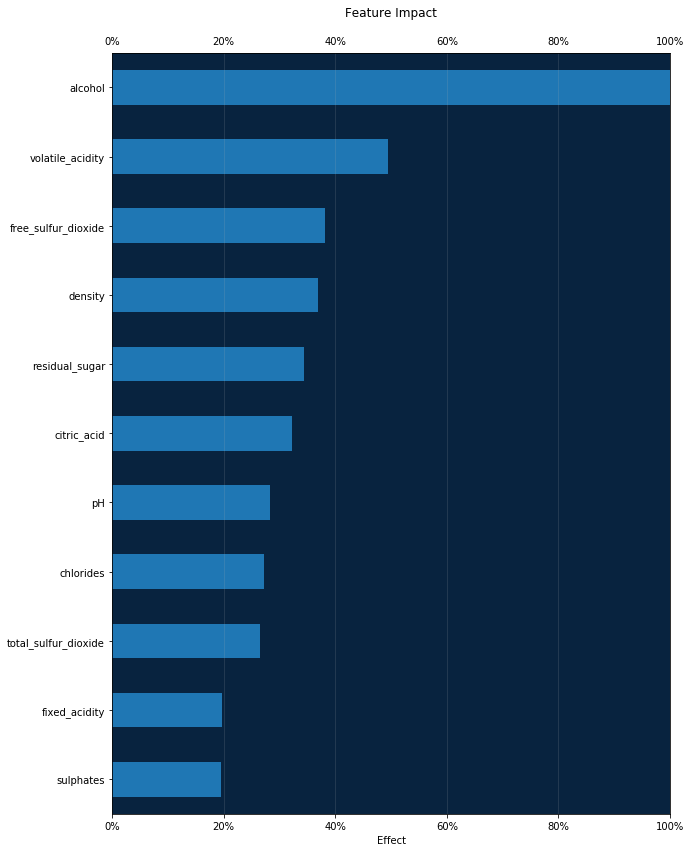

In [69]:
# Visualisation of feature importance
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Let’s set some color constants to replicate visual style of DataRobot.
dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'

# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(10, 14))
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

Along with Feature Impact DataRobot can also compute the prediction explanations for every row of the dataset. `This functionality is however not available for multiclass models.`

<a name="quick"></a>
# AUTOPILOT_MODE.QUICK

The quick mode (AUTOPILOT_MODE.QUICK) is for quickrun wherein we can run on a more limited set of models rather than the full recommended set of blueprints to get insights more quickly. In the autopilot quick mode, DataRobot built 8 models for my data in the quick mode from the 22 blueprints. We can select one of the models just like I showed above to look at the performance and to use it for getting predictions for the test data. In the quick mode DataRobot does not make any model recommendations.

In [71]:
import time
start = time.time()
project_wine2 = dr.Project.create(data_train, project_name='shaheen_dr2')
# Increase the worker count to your maximum available the project runs faster.
#project.set_worker_count(-1)
project_wine2.set_target('target', target_type=dr.enums.TARGET_TYPE.MULTICLASS, mode=dr.AUTOPILOT_MODE.QUICK)
end_dr2a = time.time()
print('Time taken to start project_wine2 = ',end_dr2a - start,'seconds')
project_wine2.wait_for_autopilot()
end_dr2b = time.time()
print('Time taken to complete autopilot quick mode = ',end_dr2b - start,'seconds')

Time taken to start project_wine2 =  28.040800094604492 seconds
In progress: 4, queued: 3 (waited: 0s)
In progress: 4, queued: 3 (waited: 0s)
In progress: 4, queued: 3 (waited: 1s)
In progress: 4, queued: 3 (waited: 2s)
In progress: 4, queued: 2 (waited: 3s)
In progress: 4, queued: 1 (waited: 5s)
In progress: 4, queued: 0 (waited: 8s)
In progress: 3, queued: 0 (waited: 15s)
In progress: 4, queued: 12 (waited: 28s)
In progress: 4, queued: 8 (waited: 49s)
In progress: 4, queued: 1 (waited: 69s)
In progress: 0, queued: 0 (waited: 89s)
Time taken to complete autopilot quick mode =  117.74620008468628 seconds


In [72]:
allblueprints = project_wine2.get_blueprints()
print(len(allblueprints))

22


In [73]:
allmodels = project_wine2.get_models()
print(len(allmodels))
allmodels

8


[Model('RandomForest Classifier (Gini)'),
 Model('AVG Blender'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (16 leaves)'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('Regularized Logistic Regression (L2)'),
 Model('TensorFlow Neural Network Classifier'),
 Model('Stochastic Gradient Descent Classifier'),
 Model('Vowpal Wabbit Classifier')]

In [74]:
example_model_quick = project_wine2.get_models(search_params={'name': "eXtreme Gradient Boosted" })[0]
# some attributes of selected model
print(example_model_quick)
print(example_model_quick.id)
print(example_model_quick.blueprint_id)

Model('eXtreme Gradient Boosted Trees Classifier')
5ca3cebb8fe98f080c791e95
39e33faad0d6f53021c923f00f033886


We can look at the performance of the selected model in more detail as I showed above and to use it for getting predictions for the test data.

<a name="manual"></a>
# AUTOPILOT_MODE.MANUAL

In the manual mode (AUTOPILOT_MODE.MANUAL), we can select which models to execute before starting the modeling process rather than use the DataRobot autopilot.

In [75]:
import time
start = time.time()
# create a project without starting it
project_wine3 = dr.Project.create(data, project_name='shaheen_dr3')
#start the project created above
project_wine3.set_target(target='target',target_type=dr.enums.TARGET_TYPE.MULTICLASS, mode=dr.AUTOPILOT_MODE.MANUAL)
end1 = time.time()
print('Time taken to start project_wine3 = ',end1 - start,'seconds')

Time taken to start project_wine3 =  28.23580002784729 seconds


If you look at the leaderboard, you will see a message : "DataRobot has not built any models for this project. To create models, add them from the Repository and, when trained, they will be listed here."

<img src="image_dr_manual.PNG">


In [76]:
# all recommended blueprints 
allblueprints = project_wine3.get_blueprints()   
print(len(allblueprints))

22


In [77]:
# We can verify that there are no models in the project at this time 
allmodels = project_wine3.get_models()
print(len(allmodels))

0


Select one of the blueprints instance from above to train a model. The default dataset for the project is used.

In [78]:
blueprint_manual = allblueprints[2]
print(blueprint_manual)

Blueprint(eXtreme Gradient Boosted Trees Classifier)


In [79]:
# some attributes of the selected blueprint
print(blueprint_manual.id)
print(blueprint_manual.project_id)
print(blueprint_manual.model_type)
print(blueprint_manual.processes)

39e33faad0d6f53021c923f00f033886
5ca3d0a8329c9135ba505a2c
eXtreme Gradient Boosted Trees Classifier
['Missing Values Imputed', 'Ordinal encoding of categorical variables', 'Matrix of word-grams occurrences', 'Stochastic Gradient Descent Classifier', 'eXtreme Gradient Boosted Trees Classifier']


In [80]:
# Train a model using 80% of the data. This train method will put a new modeling job into the queue and returns id of created ModelJob.
manualmodel_job_id = project_wine3.train(blueprint_manual, sample_pct=80)
print(manualmodel_job_id)


5


In [83]:
# Pass model_job_id to wait_for_async_model_creation function, that polls async model creation status and returns newly created model when it’s finished
from datarobot.models.modeljob import wait_for_async_model_creation

manualmodel = wait_for_async_model_creation(
    project_id = project_wine2.id,
    model_job_id = manualmodel_job_id,
)
print(manualmodel)

Model('Regularized Logistic Regression (L2)')


In [84]:
# verify that now there is one model associated with this project
print(len(project_wine3.get_models()))

1


In [85]:
# quick metrics for the model
manualmodel.metrics

{'LogLoss': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.8796240000000001,
  'validation': 0.84948},
 'AUC': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.7246859999999999,
  'validation': 0.72565},
 'Balanced Accuracy': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.543954,
  'validation': 0.56516},
 'Accuracy': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.578948,
  'validation': 0.5949}}

We can look at the performance of this model in more detail as I showed above and to use it for getting predictions for the test data.

# Delete and manage projects

It is always good to cleaup after!

In [2]:
allmyprojects = dr.Project.list()
print('all my projects - ',allmyprojects)
# load the project 
project_to_delete = allmyprojects[0]
print('project to delete - ',project_to_delete)
# delete the selected project
project_to_delete.delete()

all my projects -  [Project(shaheen_dr3), Project(shaheen_dr2), Project(shaheen_dr1)]
project to delete -  Project(shaheen_dr3)


Hope this tutorial was helpful in undertanding how DataRobot works and facilitates in integrating its rich functionality in your pythonic workflow.

Shaheen  
@Shaheen_Gauher


Author's bio:  
Shaheen Gauher is an AI communicator, an intelligent solution enabler and a Data Scientist by profession. She helps enterprises build and deploy predictive solutions to best leverage their data and empowers them to achieve more through technology and AI. She is a climate scientist and physicist by training and serves on the advisory board for Data Analytics at Tufts University Graduate School of Arts and Sciences.